Copyright **`(c)`** 2023 Ivan Magistro Contenta `<s314356@polito.it>`  
[`https://github.com/ivanmag22/computational-intelligence`](https://github.com/ivanmag22/computational-intelligence)

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

# **REMINDER**: see the *README.md* file before reeding the code

In [1032]:
import logging
#from random import random, choice, choices, randint, shuffle, uniform
import random as rnd
from functools import reduce
from collections import namedtuple
from dataclasses import dataclass
from copy import copy
import functools

from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

import lab9_lib

## Variable declaration and problem definition

In [1033]:
PROBLEM_SIZE = 1_000            # number of locis
POPULATION_SIZE = 110           # number of individuals
OFFSPRING_SIZE = 70             # number of children
N_INSTANCES = 1 # 2, 5, 10      # number of istances to pass as argument to the function that generates the problem to solve
TOURNAMENT_SIZE = 14            # useful for tournament selection
MAX_GEN_SAME_FIT = 300          # if the solution is repeated for a that number of generations, so the problem is converged

NUM_GENERATIONS = 100_000       # number of generations

In [1034]:
"""
fitness = lab9_lib.make_problem(N_INSTANCES)
for n in range(POPULATION_SIZE):
    ind = choices([0, 1], k=PROBLEM_SIZE)
    print(f"{''.join(str(g) for g in ind)}: {fitness(ind):.2%}" if PROBLEM_SIZE<=10 else f"ind {n}: {fitness(ind):.2%}")

print(fitness.calls)
"""

ind 0: 50.80%
ind 1: 47.30%
ind 2: 51.00%
ind 3: 52.00%
ind 4: 51.10%
ind 5: 48.50%
ind 6: 49.60%
ind 7: 48.20%
ind 8: 49.50%
ind 9: 48.50%
ind 10: 46.10%
ind 11: 51.70%
ind 12: 51.00%
ind 13: 50.00%
ind 14: 49.90%
ind 15: 50.10%
ind 16: 48.90%
ind 17: 49.50%
ind 18: 50.00%
ind 19: 49.40%
ind 20: 47.70%
ind 21: 48.40%
ind 22: 49.60%
ind 23: 50.00%
ind 24: 49.70%
ind 25: 49.80%
ind 26: 51.80%
ind 27: 49.50%
ind 28: 51.50%
ind 29: 50.20%
ind 30: 50.30%
ind 31: 51.90%
ind 32: 48.40%
ind 33: 49.00%
ind 34: 49.00%
ind 35: 48.90%
ind 36: 50.10%
ind 37: 50.30%
ind 38: 49.00%
ind 39: 51.00%
ind 40: 50.50%
ind 41: 51.50%
ind 42: 51.30%
ind 43: 50.10%
ind 44: 51.30%
ind 45: 48.80%
ind 46: 52.10%
ind 47: 47.80%
ind 48: 50.00%
ind 49: 49.70%
ind 50: 47.60%
ind 51: 49.90%
ind 52: 50.10%
ind 53: 51.10%
ind 54: 52.00%
ind 55: 49.50%
ind 56: 46.40%
ind 57: 50.60%
ind 58: 49.40%
ind 59: 51.70%
ind 60: 49.30%
ind 61: 51.70%
ind 62: 50.50%
ind 63: 51.00%
ind 64: 49.30%
ind 65: 50.30%
ind 66: 49.50%
ind 6

### Individual definition and parent selection

***Individual*** as a tuple containing the genome (tuple) and the fitness (float).
There are two functions to do *parent selection*:
- ***tournament()*** makes tournament selection
- ***voting()*** works as a weighted roulette wheel

In [1035]:
Individual = namedtuple("Individual", ["genome", "fitness"])

def tournament(population, tournament_size=2):
    return max(rnd.choices(population, k=tournament_size), key=lambda i: i.fitness)

# the voting mechanism is a sort of roulette wheel.
def voting(population, tournament_size=None):

    total_weight = sum(x.fitness for x in population)

    #the sum has to be equal to one
    normalized_weights = [x.fitness / total_weight for x in population]

    shuffled_weights = [(index,w) for index, w in enumerate(normalized_weights)]
    rnd.shuffle(shuffled_weights)
    random_value = rnd.uniform(0, 1)

    current_weight_sum = 0
    for index, normalized_weight in shuffled_weights:
        current_weight_sum += normalized_weight
        if current_weight_sum >= random_value:
            return population[index]

### Mutation and Recombination mechanisms

There are some functions for tweaking the individuals:
- *mutation*:
    - ***mutation()*** -> bit flip mutation
- *recombination*:
    - ***one_cut()***
    - ***n_cut()***: useful for n>1 cuts
    - ***uniform_xover()***

In [1036]:
def one_cut(g1, g2):
    cut = rnd.randint(0, PROBLEM_SIZE)
    return g1[:cut] + g2[cut:]

def n_cut(g1, g2, n):
    cut = PROBLEM_SIZE//(n+1)

    o = ()
    g = g1
    for i in range(n+1):
        start = i*cut
        if i == n:
            end = PROBLEM_SIZE
        else:
            end = i*cut + cut
        o += g[start : end]
        if g == g1:
            g = g2
        else:
            g = g1

    return o

def uniform_xover(g1, g2):
    o = []
    for i in range(len(g1)):
        o.append(rnd.choice([g1[i],g2[i]]))
    
    return tuple(o)

def mutation(g):
    point = rnd.randint(0, PROBLEM_SIZE - 1)
    return g[:point] + (1 - g[point],) + g[point + 1 :]

# NEW
def random_xover(ind1: Individual, ind2: Individual) -> Individual:
    n_genomes = int(rnd.choice(list(np.linspace(1, PROBLEM_SIZE, PROBLEM_SIZE))))
    genomes = rnd.sample(range(PROBLEM_SIZE), k=n_genomes)
    offspring = deepcopy(ind1)
    for g in genomes:
        offspring.genotype[g] = ind2.genotype[g] 
    return offspring

## Initial Population

In [1037]:
def population_init(fitness):
    population = list()

    for genome in [tuple(rnd.choices([0, 1], k=PROBLEM_SIZE)) for _ in range(POPULATION_SIZE)]:
        population.append(Individual(genome, fitness(genome)))

    return population

For **parallel model** like *island model* or *segregation* (the two implemented in this file), some variables and constants are defined:
- *NUM_NICHES*: it defines the number of niches (for segregation model) or island (for island model)
- *NUM_MIGRANTS*: it defines the number of migrants that pass from one island to another (only for island model)
- *RANDOM_NICHES*: if this constant is set to True, so niches are filled by individuals in a randomly way; otherwise they are filled in order to have individuals with similar fitness
- *MIGRATION_RATE*: it tells how many generations are needed before a new migration

In [1038]:
NUM_NICHES = 4  # niches, islands are the same thing...
NUM_MIGRANTS = 10
RANDOM_NICHES = True
MIGRATION_RATE = 50

def niches_init(population):
    niches = list()
    p = copy(population)
    if RANDOM_NICHES:
        rnd.shuffle(p)
    else:
        p.sort(key= lambda x: x.fitness)

    for i in range(NUM_NICHES):
        niches.append(p[i*POPULATION_SIZE // NUM_NICHES : (i+1)*POPULATION_SIZE // NUM_NICHES])

    # niches -> list of NUM_NICHES lists containing Individual objects

#logging.info(f"init: pop_size={len(population)}; max={max(population, key=lambda i: i.fitness)[1]}")

## Evolution

## Selection mechanisms for next generation

There are implemented three mechanisms to select the inviduals useful for the next generation:
- **steady-state GA (*steady_state()*)**: only a subset of the population is replaced in each generation, typically a small percentage of the total population. Given *POPULATION_SIZE* parents, *OFFSPRING_SIZE* children are created and added to the whole population/niche, then we take only the best *POPULATION_SIZE* individuals given by their fitness.
- **generational GA (*generational()*)**: the entire population is replaced in each generation. *Problem*: we could lose the best solution.
- **elitism (*elitism()*)**: it retains the best individuals from the current generation directly into the next generation without modification and adds the best children.

In [1039]:
def steady_state(population, offspring, size):
    """
    steady-state GA: from x parents we obtain y children and from x+y individuals we take only x ones
    """
    
    population += offspring
    population = sorted(population, key=lambda i: i.fitness, reverse=True)[:size]

    return population

def generational(population, offspring, size):
    """
    generational GA: the entire population is replaced in each generation
    """
    
    population = offspring
    population = sorted(population, key=lambda i: i.fitness, reverse=True)[:size]

    return population

def elitism(population, offspring, size):
    """
    elitism: it retains the best individuals from the current generation directly into the next generation without modification
    """
    
    population = sorted(population, key=lambda i: i.fitness, reverse=True)[:size//4]
    offspring = sorted(offspring, key=lambda i: i.fitness, reverse=True)[:size*3//4]

    return population + offspring

## Model that works on the whole population

Inspired by prof. Squillero's *one-max.ipynb* (folder 2022-23).
It is commented because I ran the parallel method. You can uncomment this, but you have to comment the following code cells.

In [1040]:
"""
selection = steady_state
best_fitness = 0
counter = 0

for g in range(NUM_GENERATIONS):
    tmp_fitness = 0
    
    offspring = list()
    for i in range(OFFSPRING_SIZE):
        if random() < 0.3:
            p = tournament(population)
            o = mutation(p.genome)
        else:
            p1 = tournament(population)
            p2 = tournament(population)
            o = one_cut(p1.genome, p2.genome)
        f = fitness(o)

        if f > tmp_fitness: # offsprings' fitness
            tmp_fitness = f
        offspring.append(Individual(o, f))
    population = selection(population, offspring, POPULATION_SIZE)
    
    if tmp_fitness <= best_fitness:
        counter += 1
        
        if counter >= 100:
            print("break at generation n.", g, "fitness: ", best_fitness)
            break
        
    elif tmp_fitness > best_fitness:
        counter = 0

        best_fitness = tmp_fitness
        if best_fitness == 1:
            print("break at generation n.", g, "fitness: ", best_fitness)
            break
    
    print("Generation",g ,"counter:", counter, "best_fitness:", best_fitness, "difference:",best_fitness-tmp_fitness)

population = sorted(population, key=lambda i: i.fitness, reverse=True)[:POPULATION_SIZE]
print(population[0])
print(fitness.calls)
"""

'\nselection = steady_state\nbest_fitness = 0\ncounter = 0\n\nfor g in range(NUM_GENERATIONS):\n    tmp_fitness = 0\n    \n    offspring = list()\n    for i in range(OFFSPRING_SIZE):\n        if random() < 0.3:\n            p = tournament(population)\n            o = mutation(p.genome)\n        else:\n            p1 = tournament(population)\n            p2 = tournament(population)\n            o = one_cut(p1.genome, p2.genome)\n        f = fitness(o)\n\n        if f > tmp_fitness: # offsprings\' fitness\n            tmp_fitness = f\n        offspring.append(Individual(o, f))\n    population = selection(population, offspring, POPULATION_SIZE)\n    \n    if tmp_fitness <= best_fitness:\n        counter += 1\n        \n        if counter >= 100:\n            print("break at generation n.", g, "fitness: ", best_fitness)\n            break\n        \n    elif tmp_fitness > best_fitness:\n        counter = 0\n\n        best_fitness = tmp_fitness\n        if best_fitness == 1:\n            pr

## Parallel methods

There are implemented two *parallel models*:
- **island model**
- **segregation**

If you want to use one of this you should comment the code cell regarding the model with the whole population and the one regarding the parallel model that we are not interested in

### Island Model

In [1041]:
def island_model(niches, fitness):
    """
    strategy = (generational, elitism)
    index = 0
    selection = strategy[index] # steady_state, generational, elitism
    """
    parent_selection = voting   # tournament
    selection = elitism # steady_state, generational

    best_fitness = [0 for _ in range(NUM_NICHES)]
    counter = [0 for _ in range(NUM_NICHES)]
    history = [[] for _ in range(NUM_NICHES)]
    
    prv_fitness = [0 for _ in range(NUM_NICHES)]
    tmp_fitness = [0 for _ in range(NUM_NICHES)]
    flag = [False for _ in range(NUM_NICHES)]   # if there are not improvements in one island, so we do not continue to search a better individual

    for i,n in enumerate(niches):
        nich = copy(n)
        f = sorted(nich, key=lambda i: i.fitness, reverse=True)[0].fitness
        tmp_fitness[i] = f

    for g in range(NUM_GENERATIONS):

        # if flag[i]=True how do we do the migration of individuals? Do we have to exclude that island?
        # maybe we have to filter the island that continue to search for a better individual

        # migration
        if g % MIGRATION_RATE == 0 and g != 0 and NUM_NICHES > 1:
            migrants = [[] for _ in range(NUM_NICHES)]
            for i,n in enumerate(niches):
                for _ in range(NUM_MIGRANTS):
                    migrants[i].append(n.pop())
                """
                c = 0
                for j in range(len(niches)):
                    if i != j:
                        if c != (NUM_NICHES - 1) - 1:
                            niches[j] += migrants[c*NUM_MIGRANTS//(NUM_NICHES-1):(c+1)*NUM_MIGRANTS//(NUM_NICHES-1)]
                        else:
                            niches[j] += migrants[c*NUM_MIGRANTS//(NUM_NICHES-1):]
                    c += 1
                """
            for i in range(NUM_NICHES):
                for j in range(NUM_NICHES):
                    if i != j:
                        for _ in range(NUM_MIGRANTS//(NUM_NICHES-1)):
                            niches[i].append(migrants[j].pop())
            for i in range(len(migrants)):
                if migrants[i]:
                    for _ in range(len(migrants[i])):
                        l = [len(x) for x in niches]
                        niches[l.index(min(l))].append(migrants[i].pop())
            
            tmp_fitness = [0 for _ in range(NUM_NICHES)]

            for i,n in enumerate(niches):
                nich = copy(n)
                f = sorted(nich, key=lambda i: i.fitness, reverse=True)[0].fitness
                tmp_fitness[i] = f
        
        # mutation and recombination
        for i,n in enumerate(niches):
            if flag[i]==True:   # we can not do better in that island
                continue
            n_size = len(n)
            offspring = list()
            history[i].append(population.copy())
            for j in range(OFFSPRING_SIZE):
                p1 = parent_selection(n, tournament_size=TOURNAMENT_SIZE)
                p2 = parent_selection(n, tournament_size=TOURNAMENT_SIZE)
                
                # mutation probability with self-adaptation
                if prv_fitness[i] * 11/10 >= tmp_fitness[i]:    # comparison between previous generation and current one
                    r = rnd.random()                                # exploration
                    if r > 0.65:
                        o = one_cut(p1.genome, p2.genome)
                    elif r > 0.35 and r <= 0.65:
                        o = uniform_xover(p1.genome, p2.genome)
                    else:
                        o = n_cut(p1.genome, p2.genome, rnd.randint(2, PROBLEM_SIZE*3//4))
                    o = mutation(o)
                else:                                           # exploitation
                    p = parent_selection(n, tournament_size=TOURNAMENT_SIZE)
                    o = mutation(p.genome)
                f = fitness(o)
                prv_fitness[i] = tmp_fitness[i]
                
                """
                r = random()
                if r > 0.65:
                    o = one_cut(p1.genome, p2.genome)
                elif r > 0.35 and r <= 0.65:
                    o = uniform_xover(p1.genome, p2.genome)
                else:
                    o = n_cut(p1.genome, p2.genome, randint(2, PROBLEM_SIZE*3//4))
                o = mutation(o)
                f = fitness(o)
                """

                if f > tmp_fitness[i]: # offsprings' fitness
                    tmp_fitness[i] = f

                offspring.append(Individual(o, f))
            n = selection(n, offspring, n_size)
        
            m = max(tmp_fitness[i])
            if m <= best_fitness[i]:
                counter[i] += 1
            
            if counter[i] >= MAX_GEN_SAME_FIT:
                print("break at generation n.", g, "fitness: ", best_fitness)
                flag[i] = True
            elif m > best_fitness[i]:
                counter[i] = 0

            best_fitness = m

        """index = 1 - index
        selection = strategy[index]"""
        
        print("Generation",g ,"counter:", counter, "best_fitness:", best_fitness)

    population = [item for sublist in niches for item in sublist]
    population = sorted(population, key=lambda i: i.fitness, reverse=True)[:POPULATION_SIZE]

    return

Generation 0 counter: 0 best_fitness: 0.557 fitness: [0.529, 0.557, 0.539, 0.531]
Generation 1 counter: 1 best_fitness: 0.557 fitness: [0.529, 0.557, 0.539, 0.542]


Generation 2 counter: 2 best_fitness: 0.557 fitness: [0.529, 0.557, 0.539, 0.542]
Generation 3 counter: 3 best_fitness: 0.557 fitness: [0.529, 0.557, 0.539, 0.542]
Generation 4 counter: 4 best_fitness: 0.557 fitness: [0.541, 0.557, 0.539, 0.542]
Generation 5 counter: 5 best_fitness: 0.557 fitness: [0.541, 0.557, 0.539, 0.542]
Generation 6 counter: 6 best_fitness: 0.557 fitness: [0.541, 0.557, 0.539, 0.542]
Generation 7 counter: 7 best_fitness: 0.557 fitness: [0.541, 0.557, 0.539, 0.542]
Generation 8 counter: 8 best_fitness: 0.557 fitness: [0.541, 0.557, 0.539, 0.542]
Generation 9 counter: 9 best_fitness: 0.557 fitness: [0.541, 0.557, 0.54, 0.542]
Generation 10 counter: 10 best_fitness: 0.557 fitness: [0.541, 0.557, 0.54, 0.542]
Generation 11 counter: 11 best_fitness: 0.557 fitness: [0.541, 0.557, 0.54, 0.542]
Generation 12 counter: 12 best_fitness: 0.557 fitness: [0.541, 0.557, 0.54, 0.542]
Generation 13 counter: 13 best_fitness: 0.557 fitness: [0.541, 0.557, 0.54, 0.542]
Generation 14

### Segregation

In [1042]:
"""
num = NUM_NICHES
selection = elitism #steady_state
parent_selection = voting   # tournament
best_fitness = 0
counter = 0
tmp_fitness = [0 for _ in range(num)]

for i,n in enumerate(niches):
    nich = copy(n)
    f = sorted(nich, key=lambda i: i.fitness, reverse=True)[0].fitness
    tmp_fitness[i] = f

for g in range(NUM_GENERATIONS):

    if g % 300 == 0 and g != 0 and NUM_GENERATIONS - g >= 300 and num > 1:  # it puts together two niches if the number of niches is higher than 1
        fa = [] # list of fitness average
        for n in niches:    # for each niche in the list of niches
            fl = [x.fitness for x in n]
            fa.append(functools.reduce(lambda a, b: a+b, fl) / len(fl)) # average fitness for each niche
        l = list(enumerate(fa))
        l.sort(key = lambda x : x[:][1])    # x is a tuple: first index -> element in the list, second index -> element in the tuple
        combined_niche = niches[l[0][0]] + niches[l[1][0]]   # it takes only the first two elements (the ones with the lowest fitness average); list of Individual objects
        combined_niche = sorted(combined_niche, key=lambda i: i.fitness, reverse=True)[:len(niches[l[0][0]]) + len(niches[l[1][0]])]
        remaining_niches = [niches[i[0]] for i in l[2:]] if num>2 else []    # list of x lists containing 
        niches = [remaining_niches[0], combined_niche] if remaining_niches else [combined_niche]
        num -= 1
        
        tmp_fitness = [0 for _ in range(num)]

        for i,n in enumerate(niches):
            nich = copy(n)
            f = sorted(nich, key=lambda i: i.fitness, reverse=True)[0].fitness
            tmp_fitness[i] = f
    
    for j,n in enumerate(niches):
        n_size = len(n)
        offspring = list()
        for i in range(OFFSPRING_SIZE):
            p1 = parent_selection(n, tournament_size=TOURNAMENT_SIZE)
            p2 = parent_selection(n, tournament_size=TOURNAMENT_SIZE)
            if random() > 0.65:
                o = one_cut(p1.genome, p2.genome)
            else:
                o = n_cut(p1.genome, p2.genome, randint(2, PROBLEM_SIZE*3//4))
            o = mutation(o)
            f = fitness(o)

            if f > tmp_fitness[j]: # offsprings' fitness
                tmp_fitness[j] = f

            offspring.append(Individual(o, f))
        n = selection(n, offspring, n_size)
    
    m = max(tmp_fitness)
    if m <= best_fitness:
        counter += 1
        
        if counter >= 300:
            print("break at generation n.", g, "fitness: ", best_fitness)
            break
        
    elif m > best_fitness:
        counter = 0

        best_fitness = m

    print("Generation",g ,"counter:", counter, "best_fitness:", best_fitness, "fitness:", tmp_fitness)

population = [item for sublist in niches for item in sublist]
population = sorted(population, key=lambda i: i.fitness, reverse=True)[:POPULATION_SIZE]
print(population[0])
print(fitness.calls)
"""

'\nnum = NUM_NICHES\nselection = elitism #steady_state\nparent_selection = voting   # tournament\nbest_fitness = 0\ncounter = 0\ntmp_fitness = [0 for _ in range(num)]\n\nfor i,n in enumerate(niches):\n    nich = copy(n)\n    f = sorted(nich, key=lambda i: i.fitness, reverse=True)[0].fitness\n    tmp_fitness[i] = f\n\nfor g in range(NUM_GENERATIONS):\n\n    if g % 300 == 0 and g != 0 and NUM_GENERATIONS - g >= 300 and num > 1:  # it puts together two niches if the number of niches is higher than 1\n        fa = [] # list of fitness average\n        for n in niches:    # for each niche in the list of niches\n            fl = [x.fitness for x in n]\n            fa.append(functools.reduce(lambda a, b: a+b, fl) / len(fl)) # average fitness for each niche\n        l = list(enumerate(fa))\n        l.sort(key = lambda x : x[:][1])    # x is a tuple: first index -> element in the list, second index -> element in the tuple\n        combined_niche = niches[l[0][0]] + niches[l[1][0]]   # it takes 

## Algorithm

In [ ]:
def solve_problem(problem_instance):
    fitness = lab9_lib.make_problem(problem_instance)

    population = population_init(fitness)
    niches = niches_init(population)

    island_model(niches, fitness)

    g = 0
    while len(history) < MAX_GENERATIONS:
        offsprings = generate_individuals(population)
        offspring = [(individual, fitness(individual)) for individual in offsprings]
        history.append(population.copy())
        population = natural_selection(population+offspring)
        #population = elitism(population, offspring)
        best_individual = population[0]
        if best_individual[1] <= best_fitness:
            counter += 1
        
            if counter >= MAX_GEN_SAME_FIT:
                print("break at generation n.", g, "fitness: ", best_fitness)
                break
            
        elif best_individual[1] > best_fitness:
            counter = 0

        best_fitness = best_individual[1]

        g += 1
    
    print(f"Best individual fitness: {best_individual[1]:.2%}")
    print("Generations: " + str(len(history)))
    print("Total fitness calls: " + str(fitness.calls))
    
    return history

In [ ]:
def plot(instance, history):
        avgs =[]
        for gen in history:        
                sum = 0
                for el in gen:
                        sum += el[1]
                avg = sum/len(gen)
                avgs.append(avg)

        maxs = []
        for gen in history:
                max = 0
                for el in gen:
                        max = el[1] if el[1] > max else max
                maxs.append(max)

        plt.title("Best fitness over the generations")
        plt.xlabel("#Generations")
        plt.ylabel("Fitness")
        plt.plot(range(len(maxs)), maxs)
        plt.savefig(f"PC{instance}_max.png")
        plt.show()
        plt.title("Average fitness over the generations")
        plt.xlabel("#Generations")
        plt.ylabel("Fitness")
        plt.plot(range(len(avgs)), avgs)
        plt.savefig(f"PC{instance}_avg.png")
        plt.show()

break at generation n. 282 fitness:  1.0
Best individual fitness: 100.00%
Generations: 283
Total fitness calls: 1702


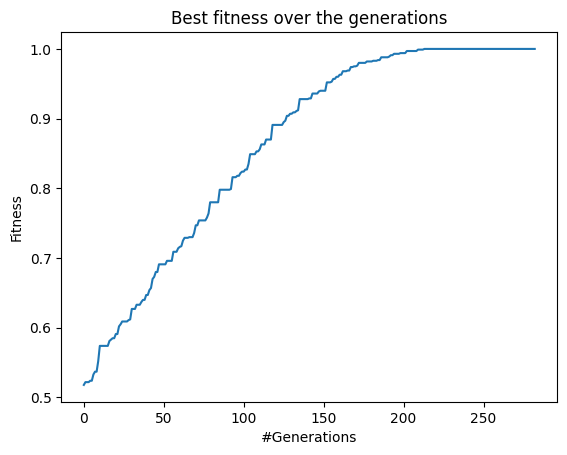

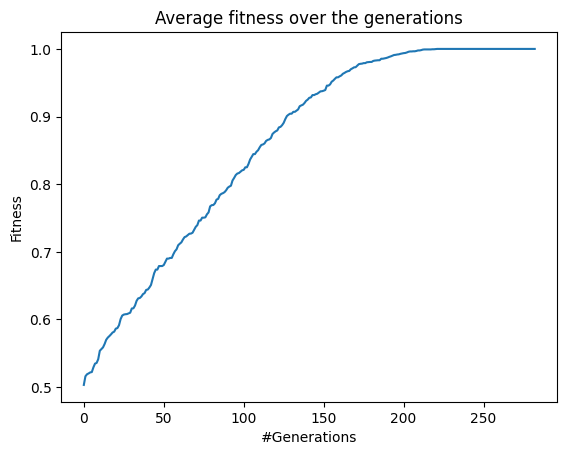

break at generation n. 80 fitness:  0.526
Best individual fitness: 52.60%
Generations: 81
Total fitness calls: 490


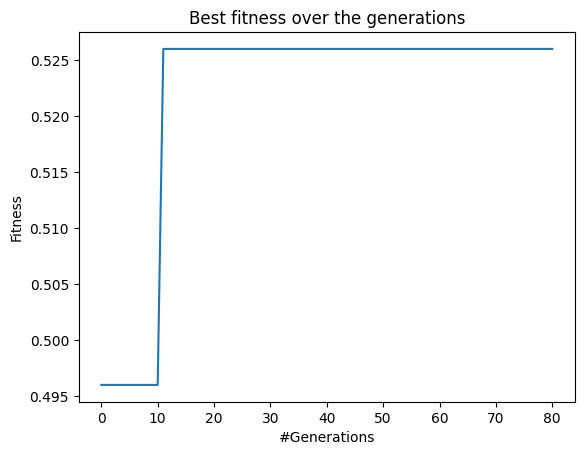

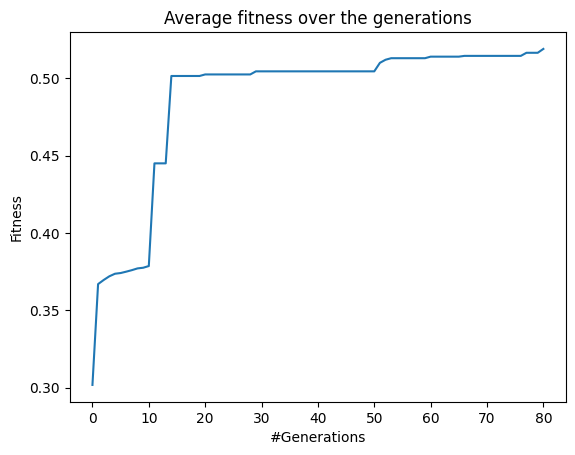

break at generation n. 95 fitness:  0.3905
Best individual fitness: 39.05%
Generations: 96
Total fitness calls: 580


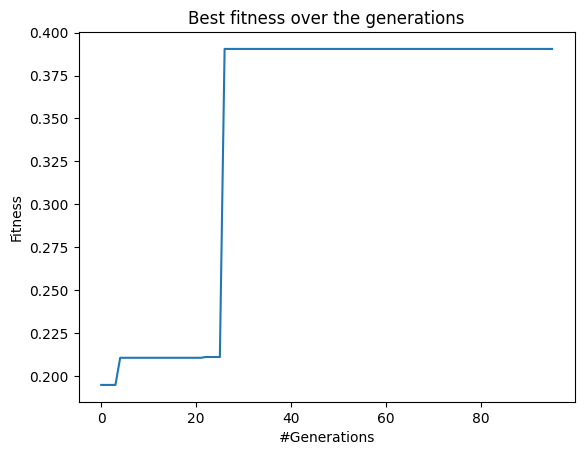

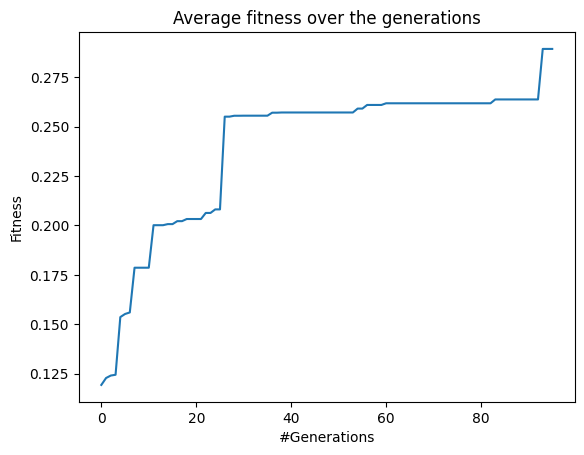

break at generation n. 144 fitness:  0.225791458
Best individual fitness: 22.58%
Generations: 145
Total fitness calls: 874


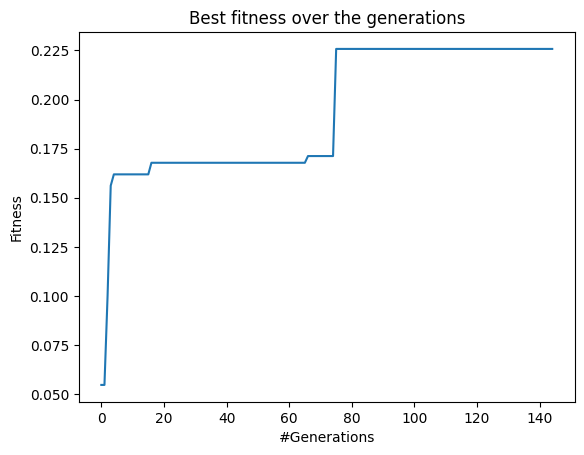

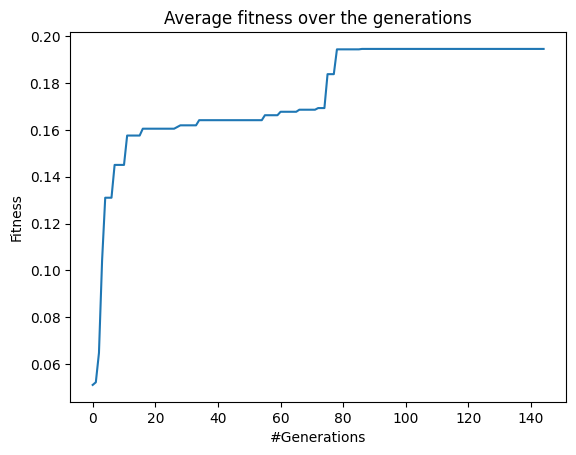

In [ ]:
for x in [1, 2, 5, 10]:
    plot(x, solve_problem(x))
